In [1]:
#install packages
!pip install pandas_ods_reader
!pip install wget

     |████████████████████████████████| 133kB 4.7MB/s 
  Created wheel for ezodf: filename=ezodf-0.3.2-py2.py3-none-any.whl size=49003 sha256=e0fdc1064e45c430d5be9e7a35e2dee7494d545c183fa56541b9459d492496a6
  Stored in directory: /root/.cache/pip/wheels/c9/6c/f9/107d39d45441980bf273757eba003ef057c6193c9d7650fac7
Successfully built ezodf
  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=32e34efd4103d3abaf7d8f5db6ae2f3e52e70a9215085f1ec619e70b253bc5eb
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
#required libraries
import wget
from pandas_ods_reader import read_ods
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import folium
import branca
import branca.colormap as cm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#gets pop density data for the UK
html = requests.get("https://en.wikipedia.org/wiki/List_of_English_districts_by_population_density#:~:text=1%2C000%20-%2010%2C000%20%2F%20km%C2%B2%20%20%20,%20%208%2C636%20%2033%20more%20rows%20").text
soup = BeautifulSoup(html)

In [4]:
#prettify
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of English districts by population density - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"87593d3d-505c-4fb3-ba8c-ae0fc3effd37","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_English_districts_by_population_density","wgTitle":"List of English districts by population density","wgCurRevisionId":1023482563,"wgRevisionId":1023482563,"wgArticleId":1934299,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short description","Short descrip

In [5]:
#takes data from soup, and arranges into 5 columns in a np array
data = []
for table in soup.find_all(name = "table",attrs={"class":"wikitable"}):
  for entry in table.tbody.find_all("td"):
    try:
      data.append(entry.a.string)
    except:
      data.append(entry.string)
data = np.array(data)
data = data.reshape(-1,5)

In [6]:
#column names
columns = ["Rank","District","Density(per km²)","Type of district","Ceremonial county"]

#dataframe creation
df_UK_POP_DENSITY = pd.DataFrame(data=data,columns=columns)

#dropping "Rank" and "Type of district"
df_UK_POP_DENSITY.drop(columns=["Rank","Type of district"],inplace=True)

#convert districts to strings
df_UK_POP_DENSITY["District"] = df_UK_POP_DENSITY["District"].astype("string")

In [7]:
#loading in city areas of the UK - was contained within a zip file, so I uploaded to github
df_UK_AREAS = pd.read_csv("https://raw.githubusercontent.com/clast-malon/Coursera_Capstone/main/SAM_LAD_DEC_2016_UK.csv")

In [8]:
#adds matching areas to a list, prints names that failed to match
areas = []
for district in df_UK_POP_DENSITY.loc[:,"District"]:
  try:
    areas.append(df_UK_AREAS.loc[df_UK_AREAS["LAD16NM"] == district, ["AREALHECT"]].iloc[0,0])
  except:
    areas.append(0)
    print(district)

Bristol
Hull
Brighton & Hove
Bournemouth, Christchurch and Poole
St Helens
Buckinghamshire
Folkestone and Hythe
East Suffolk
West Suffolk
Dorset
Somerset West and Taunton
Herefordshire


In [9]:
#add areas to dataframe
df_UK_POP_DENSITY["Area(Hectares)"] = areas

#creating dataframes for London and Manchester
df_London_pop_density = df_UK_POP_DENSITY.loc[df_UK_POP_DENSITY["Ceremonial county"] == "Greater London", ["District","Density(per km²)","Area(Hectares)"]]
df_Manchester_pop_density = df_UK_POP_DENSITY.loc[df_UK_POP_DENSITY["Ceremonial county"] == "Greater Manchester", ["District","Density(per km²)","Area(Hectares)"]]

#resetting indexes
df_London_pop_density.reset_index(drop=True,inplace=True)
df_Manchester_pop_density.reset_index(drop=True,inplace=True)

In [10]:
#specifying geolocator
geolocator = Nominatim(user_agent="UK")

In [11]:
#gets coords of all districts in london
latitudes = []
longitudes = []
for district in df_London_pop_density.loc[:,"District"]:
  i = 0
  if i<10:
    try:
      location = geolocator.geocode(f"{district},Greater London,UK")
      latitudes.append(location.latitude)
      longitudes.append(location.longitude)
    except:
      i = i+1
  else:
    latitudes.append(np.NaN)
    longitudes.append(np.NaN)
    print(district)

#adds coords to london dataframe
df_London_pop_density["Latitude"] = latitudes
df_London_pop_density["Longitude"] = longitudes

In [12]:
#gets coords of all districts in Manchester
latitudes = []
longitudes = []
for district in df_Manchester_pop_density.loc[:,"District"]:
  i = 0
  if i<10:
    try:
      location = geolocator.geocode(f"{district},Greater Manchester,UK")
      latitudes.append(location.latitude)
      longitudes.append(location.longitude)
    except:
      i = i+1
  else:
    latitudes.append(np.NaN)
    longitudes.append(np.NaN)
    print(district)

#adds coords to manchester dataframe
df_Manchester_pop_density["Latitude"] = latitudes
df_Manchester_pop_density["Longitude"] = longitudes

In [13]:
#load in foursquare credentials
CLIENT_ID = 'GWR1FEF3SNLCDYO031MWFZYVGOVB2B5L1CBRUNTZJMEI5RTG' # your Foursquare ID
CLIENT_SECRET = '1QHUWYDASJYOTR33A5O1ZISJD5QA31TAT0K4HXTQMMYMI5QK' # your Foursquare Secret
ACCESS_TOKEN = "T3AWGIXSAJJ41QDNZMQ41TJ0ZCKKJKVXIJSEHC0WHQV52DSX"
VERSION = 20210519

In [14]:
#garages in london
url = f"https://api.foursquare.com/v2/venues/search?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&near=London,UK&oauth_token={ACCESS_TOKEN}&v={VERSION}&limit=50&categoryId=52f2ab2ebcbc57f1066b8b44"
results = requests.get(url).json()
nearby_venues_London = pd.json_normalize(results["response"]["venues"])

#garages in manchester
url = f"https://api.foursquare.com/v2/venues/search?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&near=Manchester,UK&oauth_token={ACCESS_TOKEN}&v={VERSION}&limit=50&categoryId=52f2ab2ebcbc57f1066b8b44"
results = requests.get(url).json()
nearby_venues_Manchester = pd.json_normalize(results["response"]["venues"])

In [15]:
#drop columns
nearby_venues_London = nearby_venues_London[["name","location.lat","location.lng"]]
nearby_venues_Manchester = nearby_venues_Manchester[["name","location.lat","location.lng"]]

#rename columns
columns = ["Name","latitude","longitude"]
nearby_venues_London.columns = columns
nearby_venues_Manchester.columns = columns

#refresh dataframes (to avoid errors)
nearby_venues_London = pd.DataFrame(nearby_venues_London)
nearby_venues_Manchester = pd.DataFrame(nearby_venues_Manchester)

#convert names to strings
nearby_venues_London["Name"] = nearby_venues_London["Name"].astype("string")
nearby_venues_Manchester["Name"] = nearby_venues_Manchester["Name"].astype("string")

In [16]:
#removes commas from Density in London dataframe, and converts to int
density = []
for dens in df_London_pop_density.loc[:,"Density(per km²)"]:
  density.append(dens.replace(",",""))

df_London_pop_density["Density(per km²)"] = density
df_London_pop_density = df_London_pop_density.astype({"Density(per km²)":int})

#removes commas from Density in Manchester dataframe, and converts to int
density = []
for dens in df_Manchester_pop_density.loc[:,"Density(per km²)"]:
  density.append(dens.replace(",",""))

df_Manchester_pop_density["Density(per km²)"] = density
df_Manchester_pop_density = df_Manchester_pop_density.astype({"Density(per km²)":int})

In [17]:
#get vehicle data
!wget -q -O "vehicles.ods" https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/985605/veh0105.ods

In [18]:
#put into dataframe
df_UK_VEHICLES = read_ods("vehicles.ods",sheet="2020")

#get new column names
columns = df_UK_VEHICLES.loc[6,:]

#drop rows
df_UK_VEHICLES = df_UK_VEHICLES.iloc[7:468,:]

#rename columns
df_UK_VEHICLES.columns = columns

#reset index
df_UK_VEHICLES.reset_index(drop=True,inplace=True)

#convert data types
df_UK_VEHICLES["Cars"] = df_UK_VEHICLES["Cars"].astype("float64")
df_UK_VEHICLES["Light Goods Vehicles"] = df_UK_VEHICLES["Light Goods Vehicles"].astype("float64")
df_UK_VEHICLES["Region/Local Authority (Apr-2019) 3"] = df_UK_VEHICLES["Region/Local Authority (Apr-2019) 3"].astype("string")

#create new column combining car and van numbers
df_UK_VEHICLES["Cars and Vans"] = df_UK_VEHICLES.loc[:,"Cars"] + df_UK_VEHICLES.loc[:,"Light Goods Vehicles"]

In [19]:
#create new dataframe for cars and vans
df_UK_CARS = df_UK_VEHICLES[["Region/Local Authority (Apr-2019) 3","Cars and Vans"]]

#rename columns
df_UK_CARS.columns = ["Region","Cars"]

#recreate dataframe to avoid errors
df_UK_CARS = pd.DataFrame(data=df_UK_CARS)

#multiply cars by 1000 to reach real numbers
df_UK_CARS["Cars"] = df_UK_CARS.loc[:,"Cars"] * 1000

#convert float to int
df_UK_CARS["Cars"] = df_UK_CARS["Cars"].astype(int)

#remove spaces before every region
places = []
for place in df_UK_CARS.loc[:,"Region"]:
  region = place.lstrip()
  places.append(region)

#rewrite over previous region column
df_UK_CARS["Region"] = places

In [20]:
#creates list of vehicle numbers matching locations in london
cars = []
for region in df_London_pop_density.loc[:,"District"]:
  try:
    car = int(df_UK_CARS.loc[df_UK_CARS["Region"]==region,"Cars"])
    cars.append(car)
  except:
    cars.append(0)
    print(region)

#adds it to dataframe
df_London_pop_density["Cars"] = cars

#creates list of vehicle numbers matching locations in manchester
cars = []
for region in df_Manchester_pop_density.loc[:,"District"]:
  try:
    car = int(df_UK_CARS.loc[df_UK_CARS["Region"]==region,"Cars"])
    cars.append(car)
  except:
    cars.append(0)
    print(region)

#adds it to dataframe
df_Manchester_pop_density["Cars"] = cars

In [21]:
#creates Cars/Hectare column
df_London_pop_density["Cars/Hectare"] = df_London_pop_density.loc[:,"Cars"] / df_London_pop_density.loc[:,"Area(Hectares)"]
df_Manchester_pop_density["Cars/Hectare"] = df_Manchester_pop_density.loc[:,"Cars"] / df_Manchester_pop_density.loc[:,"Area(Hectares)"]

#arranges dataframes in order of car density
df_London_pop_density.sort_values("Cars/Hectare",ascending=False,inplace=True)
df_Manchester_pop_density.sort_values("Cars/Hectare",ascending=False,inplace=True)

#resets indexes
df_London_pop_density.reset_index(drop=True,inplace=True)
df_Manchester_pop_density.reset_index(drop=True,inplace=True)

#rounds car density to 1dp
df_London_pop_density["Cars/Hectare"] = df_London_pop_density["Cars/Hectare"].round(decimals=1)
df_Manchester_pop_density["Cars/Hectare"] = df_Manchester_pop_density["Cars/Hectare"].round(decimals=1)

In [22]:
#london df head
df_London_pop_density.head()

,District,Density(per km²),Area(Hectares),Latitude,Longitude,Cars,Cars/Hectare
0,Kensington and Chelsea,12884,1212.38,51.498480,-0.199043,41558,34.3
1,Hammersmith and Fulham,11308,1639.76,51.492038,-0.223640,46691,28.5
2,Islington,16097,1485.65,51.538429,-0.099905,38340,25.8
3,Lambeth,12157,2681.01,51.501301,-0.117287,68273,25.5
4,Wandsworth,9528,3426.34,51.457027,-0.193261,85314,24.9


In [23]:
#manchester df head
df_Manchester_pop_density.head()

,District,Density(per km²),Area(Hectares),Latitude,Longitude,Cars,Cars/Hectare
0,Stockport,2315,12604.02,53.407901,-2.160243,429836,34.1
1,Manchester,4735,11564.86,53.479489,-2.245115,177886,15.4
2,Bury,1911,9946.01,53.592754,-2.297283,114801,11.5
3,Trafford,2229,10604.47,53.418936,-2.359297,121112,11.4
4,Salford,2617,9719.74,53.487746,-2.289192,105636,10.9


In [24]:
#checks correlation to Cars/Hectare in london
pd.DataFrame(df_London_pop_density[["Density(per km²)","Cars","Cars/Hectare","Area(Hectares)"]].corr().iloc[2,[0,1,3]])

,Cars/Hectare
Density(per km²),0.784428
Cars,-0.720960
Area(Hectares),-0.844666


In [25]:
#checks correlation to Cars/Hectare in manchester
pd.DataFrame(df_Manchester_pop_density[["Density(per km²)","Cars","Cars/Hectare","Area(Hectares)"]].corr().iloc[2,[0,1,3]])

,Cars/Hectare
Density(per km²),0.285304
Cars,0.959771
Area(Hectares),-0.196975


Text(2315, 34.1, 'Stockport')

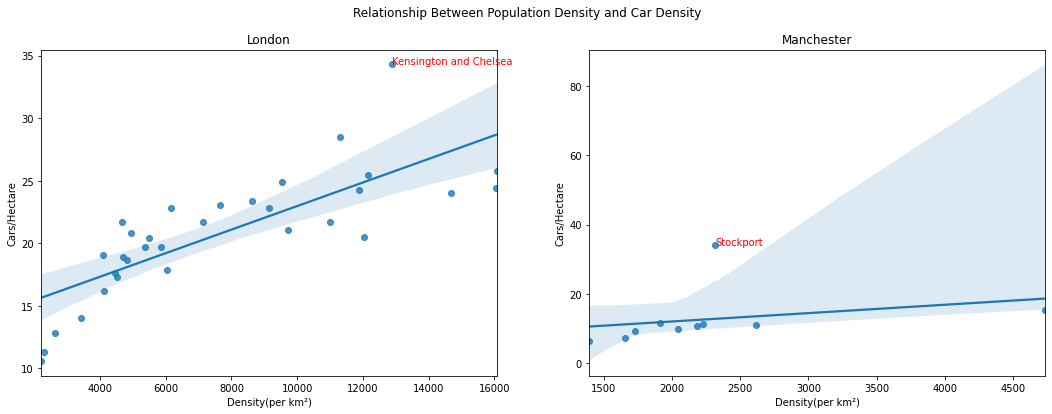

In [26]:
#regplot
fig, axes = plt.subplots(1,2, figsize=(18, 6))

fig.suptitle("Relationship Between Population Density and Car Density")

sns.regplot(ax=axes[0], data=df_London_pop_density, x="Density(per km²)", y="Cars/Hectare")
sns.regplot(ax=axes[1], data=df_Manchester_pop_density, x="Density(per km²)", y="Cars/Hectare")
axes[0].set_title("London")
axes[1].set_title("Manchester")
axes[0].text(df_London_pop_density.loc[df_London_pop_density["District"] == "Kensington and Chelsea", ["Density(per km²)"]].iloc[0,0],
             df_London_pop_density.loc[df_London_pop_density["District"] == "Kensington and Chelsea", ["Cars/Hectare"]].iloc[0,0],
             "Kensington and Chelsea", color='red')
axes[1].text(df_Manchester_pop_density.loc[df_Manchester_pop_density["District"] == "Stockport", ["Density(per km²)"]].iloc[0,0],
             df_Manchester_pop_density.loc[df_Manchester_pop_density["District"] == "Stockport", ["Cars/Hectare"]].iloc[0,0],
             "Stockport", color='red')


Text(429836, 34.1, 'Stockport')

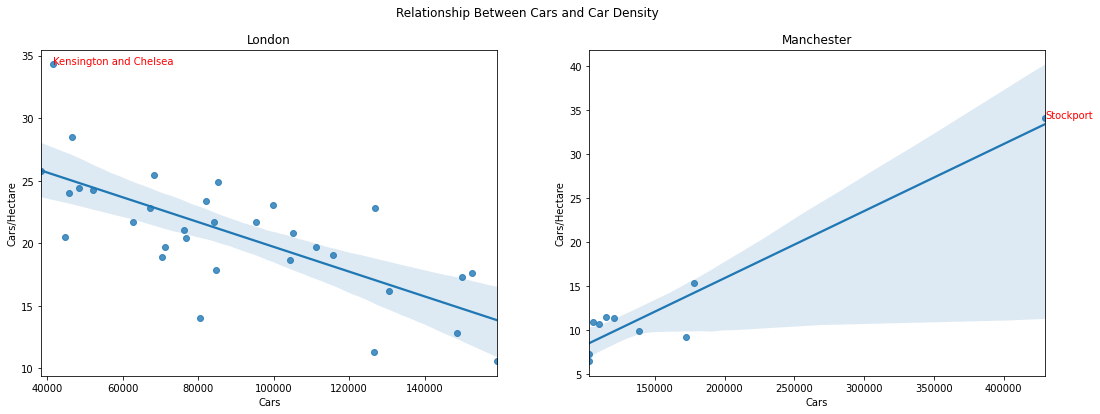

In [27]:
#regplot
fig, axes = plt.subplots(1,2, figsize=(18, 6))

fig.suptitle("Relationship Between Cars and Car Density")

sns.regplot(ax=axes[0], data=df_London_pop_density, x="Cars", y="Cars/Hectare")
sns.regplot(ax=axes[1], data=df_Manchester_pop_density, x="Cars", y="Cars/Hectare")
axes[0].set_title("London")
axes[1].set_title("Manchester")
axes[0].text(df_London_pop_density.loc[df_London_pop_density["District"] == "Kensington and Chelsea", ["Cars"]].iloc[0,0],
             df_London_pop_density.loc[df_London_pop_density["District"] == "Kensington and Chelsea", ["Cars/Hectare"]].iloc[0,0],
             "Kensington and Chelsea", color='red')
axes[1].text(df_Manchester_pop_density.loc[df_Manchester_pop_density["District"] == "Stockport", ["Cars"]].iloc[0,0],
             df_Manchester_pop_density.loc[df_Manchester_pop_density["District"] == "Stockport", ["Cars/Hectare"]].iloc[0,0],
             "Stockport", color='red')

Text(12604.02, 34.1, 'Stockport')

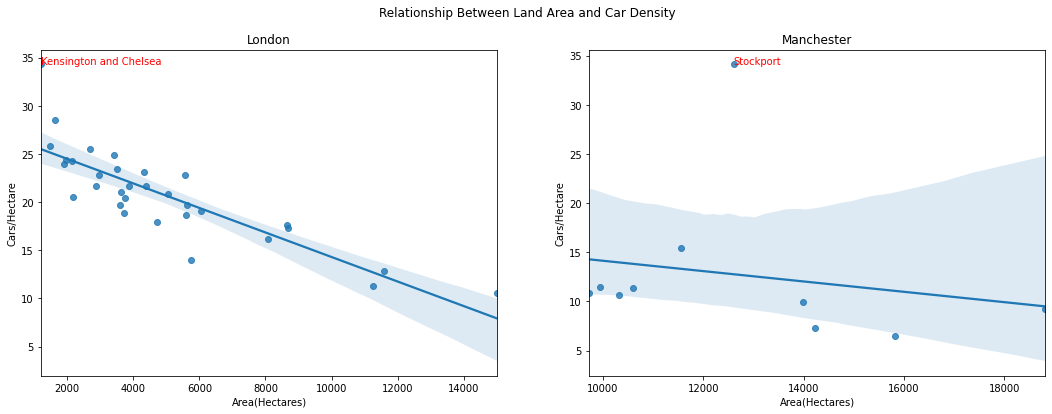

In [28]:
#regplot
fig, axes = plt.subplots(1,2, figsize=(18, 6))

fig.suptitle("Relationship Between Land Area and Car Density")

sns.regplot(ax=axes[0], data=df_London_pop_density, x="Area(Hectares)", y="Cars/Hectare")
sns.regplot(ax=axes[1], data=df_Manchester_pop_density, x="Area(Hectares)", y="Cars/Hectare")
axes[0].set_title("London")
axes[1].set_title("Manchester")
axes[0].text(df_London_pop_density.loc[df_London_pop_density["District"] == "Kensington and Chelsea", ["Area(Hectares)"]].iloc[0,0],
             df_London_pop_density.loc[df_London_pop_density["District"] == "Kensington and Chelsea", ["Cars/Hectare"]].iloc[0,0],
             "Kensington and Chelsea", color='red')
axes[1].text(df_Manchester_pop_density.loc[df_Manchester_pop_density["District"] == "Stockport", ["Area(Hectares)"]].iloc[0,0],
             df_Manchester_pop_density.loc[df_Manchester_pop_density["District"] == "Stockport", ["Cars/Hectare"]].iloc[0,0],
             "Stockport", color='red')


Text(11564.86, 4735, 'Manchester City')

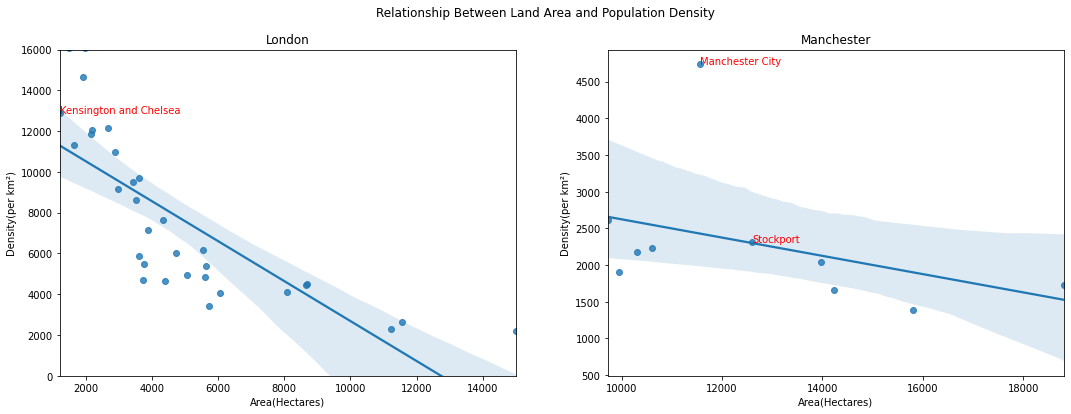

In [29]:
#regplot
fig, axes = plt.subplots(1,2, figsize=(18, 6))

fig.suptitle("Relationship Between Land Area and Population Density")

sns.regplot(ax=axes[0], data=df_London_pop_density, x="Area(Hectares)", y="Density(per km²)")
sns.regplot(ax=axes[1], data=df_Manchester_pop_density, x="Area(Hectares)", y="Density(per km²)")
axes[0].set(ylim=(0,16000))
axes[0].set_title("London")
axes[1].set_title("Manchester")
axes[0].text(df_London_pop_density.loc[df_London_pop_density["District"] == "Kensington and Chelsea", ["Area(Hectares)"]].iloc[0,0],
             df_London_pop_density.loc[df_London_pop_density["District"] == "Kensington and Chelsea", ["Density(per km²)"]].iloc[0,0],
             "Kensington and Chelsea", color='red')
axes[1].text(df_Manchester_pop_density.loc[df_Manchester_pop_density["District"] == "Stockport", ["Area(Hectares)"]].iloc[0,0],
             df_Manchester_pop_density.loc[df_Manchester_pop_density["District"] == "Stockport", ["Density(per km²)"]].iloc[0,0],
             "Stockport", color='red')
axes[1].text(df_Manchester_pop_density.loc[df_Manchester_pop_density["District"] == "Manchester", ["Area(Hectares)"]].iloc[0,0],
             df_Manchester_pop_density.loc[df_Manchester_pop_density["District"] == "Manchester", ["Density(per km²)"]].iloc[0,0],
             "Manchester City", color='red')

[Text(0, 0, 'Stockport'),
 Text(0, 0, 'Manchester'),
 Text(0, 0, 'Bury'),
 Text(0, 0, 'Trafford'),
 Text(0, 0, 'Salford'),
 Text(0, 0, 'Tameside'),
 Text(0, 0, 'Bolton'),
 Text(0, 0, 'Wigan'),
 Text(0, 0, 'Oldham'),
 Text(0, 0, 'Rochdale')]

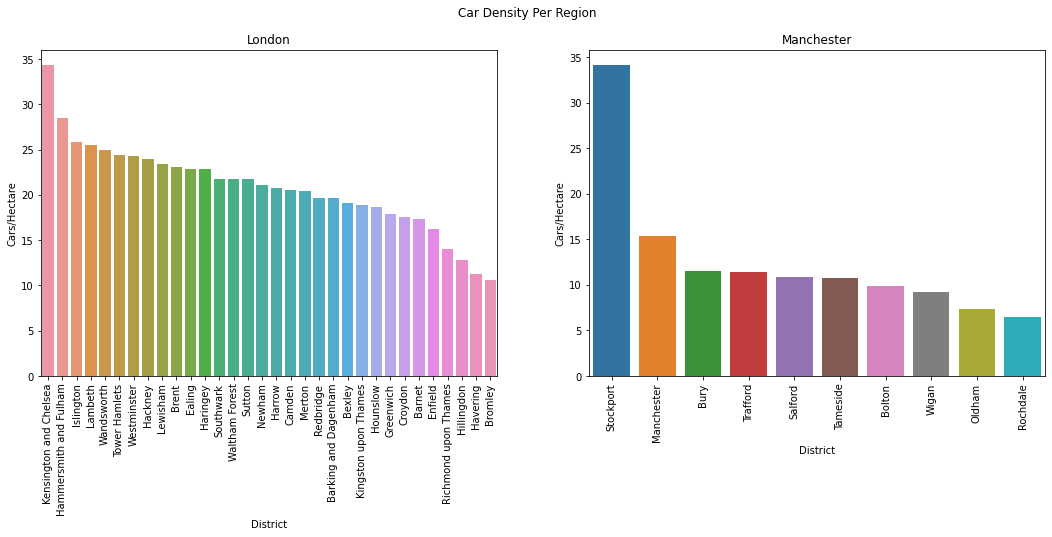

In [30]:
#bar chart
fig, axes = plt.subplots(1,2, figsize=(18, 6))

fig.suptitle("Car Density Per Region")

sns.barplot(ax=axes[0], data=df_London_pop_density, x="District", y="Cars/Hectare")
sns.barplot(ax=axes[1], data=df_Manchester_pop_density, x="District", y="Cars/Hectare")
axes[0].set_title("London")
axes[1].set_title("Manchester")
axes[0].set_xticklabels(rotation=90, labels = df_London_pop_density.loc[:,"District"])
axes[1].set_xticklabels(rotation=90, labels = df_Manchester_pop_density.loc[:,"District"])

In [31]:
#normalises car density data and adds to dataframes
df_normal = pd.concat(objs=[df_London_pop_density["Cars/Hectare"],df_Manchester_pop_density["Cars/Hectare"]])
df_normal.reset_index(inplace=True,drop=True)
npnormal = np.array(df_normal.values)
npnormal = npnormal.reshape(-1,1)
normal_dataset = StandardScaler().fit_transform(npnormal)
lonnorm = normal_dataset[0:32]
mannorm = normal_dataset[32:42]
df_London_pop_density["Carnorm"] = lonnorm
df_Manchester_pop_density["Carnorm"] = mannorm

In [32]:
#get location of london
location = geolocator.geocode("London,UK")
latitude = location.latitude
longitude = location.longitude

#create new map
map_London = folium.Map(location=[latitude,longitude], zoom_start=10)

# set color scheme
colormap = cm.LinearColormap(colors=['green','red'], index=[-1.5,2.3],vmin=-1.5,vmax=2.3,)
colormap2 = cm.LinearColormap(colors=['green','red'], index=[5,35],vmin=5,vmax=35,)

# add markers to map
regions = folium.map.FeatureGroup()
garages = folium.map.FeatureGroup()
for dis, den, lat, lon, car, carh, carnor in zip(df_London_pop_density["District"],
                                         df_London_pop_density["Density(per km²)"],
                                         df_London_pop_density["Latitude"],
                                         df_London_pop_density["Longitude"],
                                         df_London_pop_density["Cars"],
                                         df_London_pop_density["Cars/Hectare"],
                                         df_London_pop_density["Carnorm"]):
  label = f"{dis} {den} Pop(per km²) {car} Cars {carh} Cars/Hectare"
  label = folium.Popup(label, parse_html=True)
  regions.add_child(folium.CircleMarker(
      [lat, lon],
      radius=5,
      popup=label,
      color=colormap(carnor),
      fill=True,
      fill_opacity=0.7,
      parse_html=False)) 

for nam,lat,lon in zip(nearby_venues_London["Name"],nearby_venues_London["latitude"],nearby_venues_London["longitude"]):
  label = f"{nam}"
  label = folium.Popup(label, parse_html=True)
  garages.add_child(folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_opacity=0.7,
        parse_html=False)) 
    
map_London.add_child(regions)
map_London.add_child(garages)
map_London.add_child(colormap2) 
map_London

In [33]:
#get location of manchester
location = geolocator.geocode("Manchester,UK")
latitude = location.latitude
longitude = location.longitude

#create new map
map_Manchester = folium.Map(location=[latitude,longitude],zoom_start=10)

# add markers to map
regions = folium.map.FeatureGroup()
garages = folium.map.FeatureGroup()

for dis, den, lat, lon, car, carh,carnor in zip(df_Manchester_pop_density["District"],
                                   df_Manchester_pop_density["Density(per km²)"],
                                   df_Manchester_pop_density["Latitude"],
                                   df_Manchester_pop_density["Longitude"],
                                   df_Manchester_pop_density["Cars"],
                                   df_Manchester_pop_density["Cars/Hectare"],
                                   df_Manchester_pop_density["Carnorm"]):
  label = f"{dis} {den} Pop(per km²) {car} Cars {carh} Cars/Hectare"
  label = folium.Popup(label, parse_html=True)
  regions.add_child(folium.CircleMarker(
      [lat, lon],
      radius=5,
      popup=label,
      color=colormap(carnor),
      fill=True,
      fill_opacity=0.7,
      parse_html=False)) 

for nam,lat,lon in zip(nearby_venues_Manchester["Name"],nearby_venues_Manchester["latitude"],nearby_venues_Manchester["longitude"]):
  label = f"{nam}"
  label = folium.Popup(label, parse_html=True)
  garages.add_child(folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_opacity=0.7,
        parse_html=False)) 

map_Manchester.add_child(regions)
map_Manchester.add_child(garages)
map_Manchester.add_child(colormap2) 
map_Manchester

In [34]:
#checking location of Havering
location = geolocator.geocode("Havering,UK")
latitude = location.latitude
longitude = location.longitude
print(f"{latitude}N {longitude}E")

51.5443851N -0.14430716398919305E
